# Conditional Generation

In this tutorial, we show how to generate samples that are conditioned on specific values for a set of attributes. By that, we effectively create partially synthetic data, where synthetic attributes are randomly sampled given the context of a handful of pre-determined fixed attributes. Note, that the synthetic data is still statistically representative, but within the given context. The privacy of the overall dataset is then largely dependend on the privacy of the provided fixed attributes.

We will demonstrate conditional generation for two use cases:
1. First, we generate synthetic data for the UCI Adult Income, but will probe the model for an equal gender split and an uncorrelated income attribute. I.e., we will remove the gender income gap, and see how the other attributes will change accordingly.
1. Secondly, we create partially synthetic data for AirBnB listings in Manhattan, where the locations will then be actual locations, yet all other attributes are synthetic.

<img src="./conditional-generation.png" width="550px"/>

To perform either scenario, we split the original data table into two tables, that are linked together via a unique key. If that unique key does not exist yet, we will have to add one as part of pre-processing. The first table shall contain all columns, that we want to hold fixed. This table will then be uploaded as our subject table. The second table contains all other columns, that are then synthesized in the context of the first table. Once, the model is trained, we can then proceed to "Generate more data", and upload the seed context with the fixed attributes and an ID column.

Note, the same kind of conditional generation can also be performed for two-table setups. The process is even easier in that case, as the pre- and post-processing steps are not required. Once a two-table model is trained, one can simply generate more data, and provide a new subject table as the seed for the linked table.

## Use Case 1 - Rebalanced UCI Adult Income

For this use case, we will be a subset of the UCI Adult Income [[1](#refs)] dataset, consisting of 10k records and 10 attributes.

### Pre-Processing

As described above, we first have to enrich the dataset with a unique ID column, and then split the data into two tables, i.e., two CSV files.

In [1]:
import pandas as pd

df = pd.read_csv('census.csv')

# define list of columns, on which we want to condition on
ctx_cols = ['sex', 'income']
tgt_cols = [c for c in df.columns if c not in ctx_cols]

# insert unique ID column
df.insert(0, 'id', pd.Series(range(df.shape[0])))

# persist actual context, that will be used as subject table
df_ctx = df[['id'] + ctx_cols]
df_ctx.to_csv('census-context.csv', index=False)
display(df_ctx.head())

# persist actual target, that will be used as linked table
df_tgt = df[['id'] + tgt_cols]
df_tgt.to_csv('census-target.csv', index=False)
display(df_tgt.head())

,id,sex,income
0,0,Male,<=50K
1,1,Female,>50K
2,2,Male,>50K
3,3,Female,<=50K
4,4,Male,<=50K


,id,age,workclass,education,marital_status,occupation,relationship,race,hours_per_week
0,0,27,?,Bachelors,Never-married,?,Not-in-family,White,40
1,1,37,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,White,16
2,2,36,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,44
3,3,53,Private,Some-college,Divorced,Adm-clerical,Unmarried,White,38
4,4,39,?,HS-grad,Never-married,?,Not-in-family,White,40


### Train Generative Model with MOSTLY AI

1. Download `census-context.csv` from [here](./census-context.csv), and `census-target.csv` from [here](./census-target.csv).

2. Synthesize via [MOSTLY AI](https://mostly.ai/) by providing `census-context.csv` as subject table, and `census-target.csv` as linked table. You will need to define the primary / foreign key relationship accordingly. First you set `id` as a foreign key for `census-target.csv`, and then you set `id` as a primary key for `census-context.csv`. Otherwise you can leave all settings at their default, and just proceed to launch job.

<img src='./screen1.1.png' width="400px"/> <img src='./screen1.2.png' width="400px"/><br /><img src='./screen1.3.png' width="400px"/> <img src='./screen1.4.png' width="400px"/>

### Generate More Data with MOSTLY AI

Let's create a CSV file, with specific values for the fixed attributes, and use that as a seed for "Generate more data".

In [2]:
import numpy as np
np.random.seed(1)

n = 10_000
p_inc = (df.income=='>50K').mean()
seed = pd.DataFrame({
    'id': [f's{i:04}' for i in range(n)],
    'sex': np.random.choice(['Male', 'Female'], n, p=[.5, .5]),
    'income': np.random.choice(['<=50K', '>50K'], n, p=[1-p_inc, p_inc]),
})
seed.to_csv('census-seed.csv', index=False)
display(seed)

,id,sex,income
0,s0000,Male,>50K
1,s0001,Female,<=50K
2,s0002,Male,<=50K
3,s0003,Male,>50K
4,s0004,Male,<=50K
...,...,...,...
9995,s9995,Female,<=50K
9996,s9996,Male,<=50K
9997,s9997,Male,<=50K
9998,s9998,Male,<=50K


Download `census-seed.csv` from [here](./census-seed.csv), and upload that file as part of the "Generate more data with seed" dialog. Launch the job, and once finished, simply download as CSV file.

<img src='./screen1.5.png' width="400px"/> <img src='./screen1.6.png' width="400px"/>

### Post-Processing

In [3]:
# upload synthetic dataset
import pandas as pd
try:
    # check whether we are in Google colab
    from google.colab import files
    print("running in COLAB mode")
    import io
    uploaded = files.upload()
    syn = pd.read_csv(io.BytesIO(list(uploaded.values())[0]))
    print(f"uploaded synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")
except:
    print("running in LOCAL mode")
    print("adapt `syn_file_path` to point to your generated synthetic data file")
    syn_file_path = './census-target_syn.csv'
    syn = pd.read_csv(syn_file_path)
    print(f"read synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")

# merge fixed seed with synthetic target to a single partially synthetic dataset
syn = pd.merge(seed, syn, on='id')
syn

running in LOCAL mode
adapt `syn_file_path` to point to your generated synthetic data file
read synthetic data with 10,000 records and 9 attributes


,id,sex,income,age,workclass,education,marital_status,occupation,relationship,race,hours_per_week
0,s0000,Male,>50K,51,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,40
1,s0001,Female,<=50K,46,Federal-gov,HS-grad,Never-married,Tech-support,Not-in-family,White,40
2,s0002,Male,<=50K,28,Private,HS-grad,Never-married,Handlers-cleaners,Unmarried,Black,40
3,s0003,Male,>50K,39,Local-gov,Masters,Married-civ-spouse,Prof-specialty,Husband,White,40
4,s0004,Male,<=50K,67,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,20
...,...,...,...,...,...,...,...,...,...,...,...
9995,s9995,Female,<=50K,44,Private,HS-grad,Divorced,Adm-clerical,Own-child,White,40
9996,s9996,Male,<=50K,70,?,HS-grad,Married-civ-spouse,?,Husband,White,2
9997,s9997,Male,<=50K,37,Private,HS-grad,Divorced,Craft-repair,Not-in-family,White,40
9998,s9998,Male,<=50K,40,Private,Some-college,Divorced,Craft-repair,Not-in-family,White,40


### Analyse

Let's compare the age distribution of records from the the original data vs. from the partially synthetic data. As we will see, the synthesized women are now significantly older, in order to meet the criteria of removing the gender income gap.

In a similar vein, you can now study other shifts in the distributions, that are the consequence of the provided seed data.

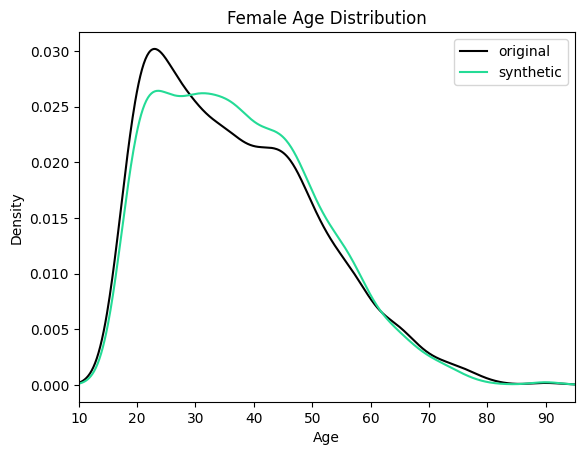

In [4]:
import matplotlib.pyplot as plt

plt.xlim(10, 95)
plt.title('Female Age Distribution')
plt.xlabel('Age')
df[df.sex=='Female'].age.plot.kde(color='black', bw_method=0.2)
syn[syn.sex=='Female'].age.plot.kde(color='#24db96', bw_method=0.2)
plt.legend({'original': 'black', 'synthetic': '#24db96'})
plt.show()

## Use Case 2 - Partially Synthetic Geo Data

For this use case, we will be using 2019 AirBnB listings [[2](#refs)] for Manhattan. The dataset consists of 21,661 records, and 10 mixed-type columns, with two of those representing the latitude and longitude of the listing. We will use this dataset to create synthetic attributes for all the actual locations, that were contained in the original.

### Pre-Processing

We again, will enrich the DataFrame with an `id` column, and then split into two DataFrames, `airbnb-context.csv` and `airbnb-target.csv`.

In addition, we will need to concatenate `latitude` and `longitude` together into a single column, as this is the format expected by MOSTLY AI, in order to improve its representation of geo information.

In [5]:
import pandas as pd

df_orig = pd.read_csv('airbnb.csv')
display(df_orig.head())

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews
0,Upper West Side,40.79901,-73.96135,Private room,58,30,0
1,Upper West Side,40.78000,-73.98249,Entire home/apt,150,30,48
2,Washington Heights,40.85604,-73.93469,Entire home/apt,100,30,13
3,Harlem,40.82501,-73.95125,Entire home/apt,100,3,1
4,Harlem,40.80131,-73.95790,Private room,45,7,2


In [6]:
df = df_orig.copy()

# concatenate latitude and longitude to "LAT, LONG" format
df['LAT_LONG'] = df['latitude'].astype(str) + ', ' + df['longitude'].astype(str)
df = df.drop(columns=['latitude', 'longitude'])

# define list of columns, on which we want to condition on
ctx_cols = ['neighbourhood', 'LAT_LONG']
tgt_cols = [c for c in df.columns if c not in ctx_cols]

# enricht with ID column
df.insert(0, 'id', pd.Series(range(df.shape[0])))

# persist actual context, that will be used as subject table
df_ctx = df[['id'] + ctx_cols]
df_ctx.to_csv('airbnb-locations.csv', index=False)
display(df_ctx.head())

# persist actual target, that will be used as linked table
df_tgt = df[['id'] + tgt_cols]
df_tgt.to_csv('airbnb-data.csv', index=False)
display(df_tgt.head())

,id,neighbourhood,LAT_LONG
0,0,Upper West Side,"40.79901, -73.96135"
1,1,Upper West Side,"40.78, -73.98249"
2,2,Washington Heights,"40.85604, -73.93469"
3,3,Harlem,"40.82501, -73.95125"
4,4,Harlem,"40.80131, -73.9579"


,id,room_type,price,minimum_nights,number_of_reviews
0,0,Private room,58,30,0
1,1,Entire home/apt,150,30,48
2,2,Entire home/apt,100,30,13
3,3,Entire home/apt,100,3,1
4,4,Private room,45,7,2


### Train Generative Model with MOSTLY AI

1. Download `airbnb-locations.csv` from [here](./airbnb-locations.csv), and `airbnb-data.csv` from [here](./airbnb-data.csv).

2. Synthesize via [MOSTLY AI](https://mostly.ai/) by providing `airbnb-locations.csv` as subject table, and `airbnb-data.csv` as linked table. You will need to define the primary / foreign key relationship accordingly. Plus, you need to configure column `LAT_LONG` as encoding type `Lat, Long`. In addition you can also shorten the training for the locations by setting Trainnig Goal to `Speed`. The quality of that model will actually not be relevant, as we will feed actual locations to the synthesis later on.  Otherwise you can leave all settings at their default, and just proceed to launch job.

<img src='./screen2.1.png' width="400px"/> <img src='./screen2.2.png' width="400px"/>

### Generate More Data with MOSTLY AI

Once the training has finished, we can generate partially synthetic data by simply re-uploading the original `airbnb-locations.csv` as seed file to the "generate more data" form. Once the data has been generated, download the data as CSV file again.

### Post-Processing

In [9]:
# upload synthetic dataset
import pandas as pd
try:
    # check whether we are in Google colab
    from google.colab import files
    print("running in COLAB mode")
    import io
    uploaded = files.upload()
    syn = pd.read_csv(io.BytesIO(list(uploaded.values())[0]))
    print(f"uploaded synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")
except:
    print("running in LOCAL mode")
    print("adapt `syn_file_path` to point to your generated synthetic data file")
    syn_file_path = './airbnb-data_syn.csv'
    syn = pd.read_csv(syn_file_path)
    print(f"read synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")

# merge fixed seed with synthetic target to a single partially synthetic dataset
syn_partial = pd.merge(df_ctx, syn, on='id')

# split LAT_LONG into separate columns again
syn_partial = pd.concat([
    syn_partial, 
    syn_partial.LAT_LONG.str.split(', ', n=2, expand=True).rename(columns={0: 'latitude', 1: 'longitude'}).astype(float),
], axis=1).drop(columns='LAT_LONG')

# restore column order
syn_partial = syn_partial[df_orig.columns]

syn_partial.head()

running in LOCAL mode
adapt `syn_file_path` to point to your generated synthetic data file
read synthetic data with 21,661 records and 5 attributes


,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews
0,Upper West Side,40.79901,-73.96135,Entire home/apt,78,2,5
1,Upper West Side,40.78000,-73.98249,Entire home/apt,250,30,0
2,Washington Heights,40.85604,-73.93469,Entire home/apt,81,7,46
3,Harlem,40.82501,-73.95125,Private room,49,2,6
4,Harlem,40.80131,-73.95790,Private room,300,2,1


### Analyze

Let's compare the price distribution across Manhatten. Note again, that while the locations in the partially synthetic data are actual locations, all other attributes, incl. the price per night, are randomly sampled by the generative model. Still, these prices are again statistically representative given the context, i.e. the location within Manhattan.

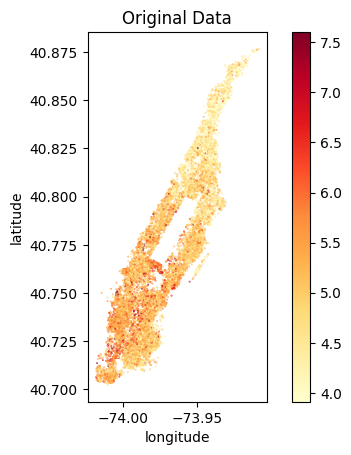

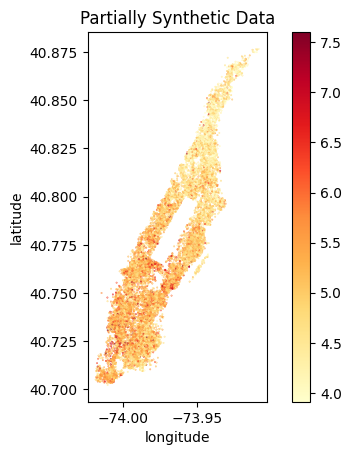

In [12]:
def plot_manhatten(df, title):
    ax = df_orig.plot.scatter(
        x='longitude', 
        y='latitude', 
        s=0.1, 
        alpha=1, 
        color=np.log(df.price.clip(lower=50, upper=2_000)),
        cmap=plt.colormaps['YlOrRd'],
    )
    ax.set_aspect(1.3)
    ax.set_title(title)
    plt.show()
    
plot_manhatten(df_orig, 'Original Data')
plot_manhatten(syn_partial, 'Partially Synthetic Data')

Note, that you can also create a fully synthetic data, and will also yield statistically representative locations with their attributes. However, as these locations do not necessarily exist (e.g. they might end up in the Hudson River), the demonstrated approach allows you to combine the best of both worlds. 

## Conclusion

In this tutorial we walked throught the process of conditional generation to yield partially synthetic data. This allows you to probe the generative model with a specific context, whether that is hypothetical (use case 1) or real (use case 2), and gain corresponding insights for specific scenarios.

## Further exercises

In addition to walking through the above instructions, we suggest..
* to use a different set of fixed columns for the US Census dataset
* to generate a very large number of records for a fixed value set, e.g. create 1 million records of 48 year old female Professors
* to perform a fully synthetic dataset of the AirBnB Manhattan dataset

## References<a class="anchor" name="refs"></a>

1. https://archive.ics.uci.edu/ml/datasets/adult
1. http://insideairbnb.com/get-the-data
